In [1]:
# Import the necessary Python libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import log10
import math
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import os.path
import csv
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
DATA_DIR = "/collobrative_transport/data"

In [17]:
ROBOTS = [25,50,100]
PATH_TAKEN = ['straight', 'zigzac', 'straight_rot']
INTER_CAGE_DIST =0.45 # 0.65, 0.85
MASS = 5
OBJECT_SHAPE = [0,1,2]
STATE=[0,1] # 0-> caging 1-> pushing
REP=30
TARGET_x=[-10,-10]
TARGET_y=[-0,-2]
TARGET_TOLERENCE = 0.1
TIME_STEP=10

In [4]:
print("EXPERIMENTAL DATA FILES STATS")
for robot in ROBOTS:
    for path in PATH_TAKEN:
        
        object_shape = 0
        if(robot == 50):
            object_shape = 1
        elif(robot == 100):
            object_shape = 2
        for movement in [0]:
            for rep in range(1,REP+1):
                if (not os.path.exists(DATA_DIR+"/pos_"+str(robot)+'_'+path+'_'
                                      +str(INTER_CAGE_DIST)+'_'+str(MASS)+'_'
                                      +str(object_shape)+'_'+str(rep)
                                      +'.csv')) or (not os.path.exists(DATA_DIR
                                      +"/perf_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'
                                      +str(MASS)+'_'+str(object_shape)+'_'+str(rep)
                                      +'.csv')) or (not os.path.exists(DATA_DIR
                                      +"/effec_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'
                                      +str(MASS)+'_'+str(object_shape)+'_'+str(rep)+'.csv')):
                    print("EXP: ROBOT {} PATH {} REP {} does not exist".format(robot,path,rep))
                    print(DATA_DIR+"/pos_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'+str(MASS)+'_'+str(object_shape)+'_'+str(rep)+'.csv')
                    

EXPERIMENTAL DATA FILES STATS
EXP: ROBOT 25 PATH straight_rot REP 21 does not exist
/collobrative_transport/data/pos_25_straight_rot_0.45_5_0_21.csv
EXP: ROBOT 100 PATH straight REP 5 does not exist
/collobrative_transport/data/pos_100_straight_0.45_5_2_5.csv
EXP: ROBOT 100 PATH zigzac REP 5 does not exist
/collobrative_transport/data/pos_100_zigzac_0.45_5_2_5.csv
EXP: ROBOT 100 PATH straight_rot REP 5 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_5.csv
EXP: ROBOT 100 PATH straight_rot REP 13 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_13.csv
EXP: ROBOT 100 PATH straight_rot REP 29 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_29.csv


In [5]:
def get_names_for_posfile(robot):
    name = ['time']
    for i in range(0,robot):
        name.append('id:'+str(i))
        name.append('x_'+str(i))
        name.append('y_'+str(i))
        name.append('z_'+str(i))
    name.append('obj_x')
    name.append('obj_y')
    name.append('obj_yaw')
    return name
def get_names_for_effecfile(robot):
    name = ['time']
    for i in range(0,robot):
        name.append('id:'+str(i))
        name.append('ep_'+str(i))
        name.append('er_'+str(i))
        name.append('task_'+str(i))
        name.append('c_size_'+str(i))
        name.append('p_size_'+str(i))
        name.append('r_size_'+str(i))
        name.append('t_size_'+str(i))
    return name

In [6]:
# Reads the data of a single experiment
def read_pos_datafile(name, robot):
    fname = DATA_DIR + "/pos_" + name
    print('Reading: '+fname+'.csv')
    names = get_names_for_posfile(robot)
    if not os.path.exists(fname+'.csv'):
        print("File does not exsist "+fname+'.csv')
        return pd.DataFrame()
    return pd.read_csv(fname+'.csv', names=names, header=None, skiprows=1, engine='python')
# Reads the data of a single experiment
def read_effec_datafile(name, robot):
    fname = DATA_DIR + "/effec_" + name
    print('Reading: '+fname+'.csv')
    names = get_names_for_effecfile(robot)
    if not os.path.exists(fname+'.csv'):
        print("File does not exsist "+fname+'.csv')
        return pd.DataFrame()
    return pd.read_csv(fname+'.csv', names=names, header=None, skiprows=1, engine='python')
def read_perf_datafile(name, robot):
    fname = DATA_DIR + "/perf_" + name
    print('Reading: '+fname+'.csv')
    try:
        data = pd.read_csv(fname+'.csv', header=None, skiprows=0, engine='python')
        return data
    except:
        print('Empty csv file!')
        return pd.DataFrame()
    

In [7]:
def get_task_time(c_df, robot):
    task_times =[]
    if(not c_df.empty):
        for d in range(0,robot):
            task_index=1
            robot_time=[]
            for i in range(0,11):
                TTime = c_df[c_df['task_'+str(d)] == task_index].index.tolist()
                if(len(TTime) > 0):
                    robot_time.append(TTime[0])
                task_index = task_index +2
            task_times.append(robot_time)
    return task_times

In [8]:
def get_rotator_task_time(c_df, robot):
    task_times =[]
    if(not c_df.empty):
        for d in range(0,robot):
            task_index=0
            robot_time=[]
            for i in range(0,11):
                TTime = c_df[c_df['task_'+str(d)] == task_index].index.tolist()
                if(len(TTime) > 0):
                    robot_time.append(TTime[0])
                task_index = task_index +2
            task_times.append(robot_time)
    return task_times

In [9]:
get_task_time(read_effec_datafile('25_straight_0.45_5_0_1',25),25)

Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_1.csv


[[2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [2858, 2969, 3082, 3198, 3313, 3422, 3537, 3652, 3767, 3885],
 [],
 [],
 [2858, 2969, 3082, 

In [10]:
def compute_effec_push_rotater(name, robot):
    c_df = read_effec_datafile(name,robot)
    task_time = get_task_time(c_df,robot)
#     rot_task_time = rot_task_time(c_df,robot)
    num_pushers =[]
    num_rotaters =[]
    if(len(task_time) > 0 and (not c_df.empty)):
        for i in range(0,10):
            pusher = 0 
            rotator = 0
            for d in range(0,robot):
                if(len(task_time[d]) > 0 and len(task_time[d]) > i):
                    c_time = task_time[d][i]
                    if(c_df['ep_'+str(d)][c_time-10] == 1):
                        pusher = pusher+1
                    if(len(c_df) > c_time+10):
                        c_time=c_time+10
                    if(c_df['er_'+str(d)][c_time] == 1):
                        rotator = rotator+1
            num_pushers.append(pusher)
            num_rotaters.append(rotator)
    return num_pushers,num_rotaters

In [11]:
compute_effec_push_rotater('100_straight_0.45_5_2_1',100)

Reading: /collobrative_transport/data/effec_100_straight_0.45_5_2_1.csv


([47, 35, 33, 41, 38, 38, 44, 38, 58, 58],
 [47, 43, 39, 37, 37, 35, 31, 32, 31, 39])

In [12]:
def obtain_push_rot_Table_for_all_run(robots, path, obj_shape):
    pusher_Table=[]
    rotator_Table=[]
    for i in range(1,REP+1):
        pusher,rotator = compute_effec_push_rotater(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots)
        pusher_Table.append(pusher)
        rotator_Table.append(rotator)
    return pusher_Table,rotator_Table

In [13]:
# Makes a series of raw data out of a set of experiments
def static_make_series_data(robots, path, obj_shape, wp, state, pusher_Table,rotator_Table):
    # Create series to contain the result
    res = pd.Series()
    res.set_value(0, robots)   
    res.set_value(1, obj_shape)
    res.set_value(2, path)
    res.set_value(3, wp)
    res.set_value(4, state)
    
    for i in range(0,REP):
        if (state == 0):
            if(len(pusher_Table) > 0 and len(pusher_Table[i]) > 0):
                res.set_value(i+5, pusher_Table[i][wp])
        elif(state == 1):
            if(len(rotator_Table) > 0 and len(rotator_Table[i]) > 0):
                res.set_value(i+5, rotator_Table[i][wp])
    return res

# Makes a complete table of raw data
def static_make_table_data():
    # Store data here
    df = pd.DataFrame()
    # Fill in the data, one series at a time
    for robots in ROBOTS:
        for path in PATH_TAKEN:
            obj_shape = 0
            if(robots == 50):
                obj_shape = 1
            elif(robots == 100):
                obj_shape = 2 
            pusher_Table,rotator_Table = obtain_push_rot_Table_for_all_run(robots, path, obj_shape)
            for wp in range(0,10):
                for state in [0,1]:
                    df = df.append(static_make_series_data(robots, path, obj_shape, wp, state, pusher_Table,rotator_Table), ignore_index=True)
    
    # Return the dataframe
    df.set_index([0, 1, 2, 3, 4], inplace=True)
    df.index.names = ["robots", "Object_shape", "path", "WP", "p/r"]
    df.columns = range(1, REP+1)
    return df

In [14]:
data = static_make_table_data()

Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_1.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_2.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_3.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_4.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_5.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_6.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_7.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_8.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_9.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_10.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_11.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_12.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_13.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_14.csv
R

Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_24.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_25.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_26.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_27.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_28.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_29.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_30.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_1.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_2.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_3.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_4.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_5.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_6.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_7.csv
Reading: /col

Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_15.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_16.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_17.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_18.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_19.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_20.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_21.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_22.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_23.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_24.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_25.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_26.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_27.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_28.csv
Readin

In [16]:
data.stack().groupby(level=[0,1,2,3,4]).describe().unstack()

count       mean        std  min  \
robots Object_shape path         WP p/r                                     
25     0            straight     0  0       30   8.366667   1.159171    6   
                                    1       30   9.866667   0.860366    8   
                                 1  0       30   8.966667   1.129032    7   
                                    1       30  10.133333   0.730297    9   
                                 2  0       30   9.000000   1.681543    7   
                                    1       30   9.900000   0.922889    8   
                                 3  0       30   8.733333   1.387961    7   
                                    1       30   9.666667   0.802296    7   
                                 4  0       30   9.166667   1.763291    7   
                                    1       30   9.666667   0.884087    8   
                                 5  0       30   8.900000   1.422722    7   
                                    1       30   9.800000   0.886683    8   
                                 6  0       30   8.633333   1.376736    7   
                                    1       30   9.600000   1.003442    8   
                                 7  0       30   8.900000   1.787890    6   
                                    1       30   9.633333   1.066200    8   
                                 8  0       30   8.900000   1.539144    6   
                                    1       30   9.833333   1.053183    7   
                                 9  0       30   8.866667   1.306043    7   
                                    1       30  10.100000   1.093870    8   
                    straight_rot 0  0       29   8.379310   1.177582    6   
                                    1       29   9.862069   0.875220    8   
                                 1  0       29   8.931034   1.131719    7   
                                    1       29   9.931034   0.961065    8   
                                 2  0       29   9.206897   2.144417    6   
                                    1       29   9.724138   0.959782    8   
                                 3  0       29   9.448276   1.702649    7   
                                    1       29   9.758621   1.154345    8   
                                 4  0       29   9.620690   2.025089    7   
                                    1       29   9.827586   1.037475    8   
...                                        ...        ...        ...  ...   
100    2            straight_rot 5  0       27  41.962963   6.953037   27   
                                    1       27  41.370370   3.628394   34   
                                 6  0       27  34.074074  12.098716   14   
                                    1       27  45.074074   2.630091   40   
                                 7  0       27  62.333333   3.100868   52   
                                    1       27  47.777778   4.610467   42   
                                 8  0       27  71.703704   2.366673   67   
                                    1       27  48.962963   4.407000   40   
                                 9  0       27  32.444444  31.097036    0   
                                    1       27  23.333333  22.407073    0   
                    zigzac       0  0       29  25.034483   3.469075   18   
                                    1       29  43.517241   1.404602   39   
                                 1  0       29  29.000000   5.063878   21   
                                    1       29  43.310345   2.285098   36   
                                 2  0       29  31.724138   6.250123   17   
                                    1       29  40.931034   1.998768   36   
                                 3  0       29  33.586207   5.870734   23   
                                    1       29  39.551724   4.281073   27   
                                 4  0       29  43.068966   5.463718   30   
                                    1

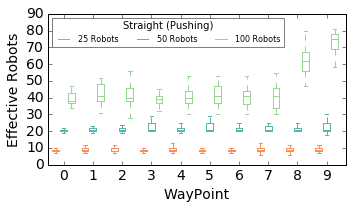

In [51]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    

# Create figure and axes
fig = plt.figure(figsize=(5,3))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
# Plot axes
ax = fig.add_subplot(111)

titles = ['Straight', 'ZigZac', 'Straight_Rot']
task =['Pushing', 'Rotating']
robot_1 = []
robot_2 = []
robot_3 = []
path='straight'
for wp in range(0,10):
        robot_1.append((data.stack()[25][0][path][wp][0]))
        robot_2.append((data.stack()[50][1][path][wp][0]))
        robot_3.append((data.stack()[100][2][path][wp][0]))

lin_1 = plt.boxplot(robot_1, positions=np.array(xrange(10))*3.0-0.8, sym='', widths=0.7)
lin_2 = plt.boxplot(robot_2, positions=np.array(xrange(10))*3.0, sym='', widths=0.7)
lin_3 = plt.boxplot(robot_3, positions=np.array(xrange(10))*3.0+0.8, sym='', widths=0.7)


set_box_color(lin_1, '#fc8d59') # colors are from http://colorbrewer2.org/
set_box_color(lin_2, '#5ab4ac')
set_box_color(lin_3, '#99d594')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#fc8d59', label='25 Robots')
plt.plot([], c='#5ab4ac', label='50 Robots')
plt.plot([], c='#99d594', label='100 Robots')

ax.legend(title=titles[0]+' ('+task[0]+')', loc=2,ncol=3,framealpha=0.5,fontsize=8)
plt.xticks(np.array(xrange(10))*3.0,range(0,10))
plt.xlim(-1.6, 29.0)
# plt.ylim(0, 90)
plt.tight_layout(pad=2)

ax.set_ylabel("Effective Robots",fontsize=14)
ax.set_xlabel("WayPoint",fontsize=14)
# plt.savefig("/home/vivek/Vivek/Projects/Hierarchical_Swarm/KheperaIV/data_processing/plots/time_taken_state.pdf", dpi=600, format="pdf", transparent=False)

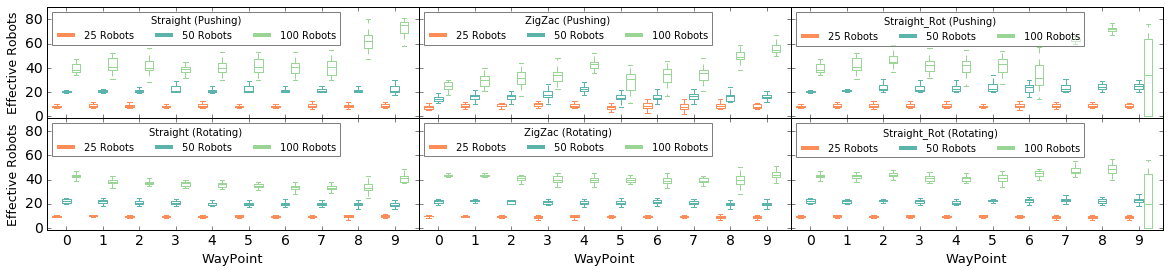

In [76]:
fig, ax = plt.subplots(2, 3, sharex='col',sharey='row',figsize=(20,4))
plt.subplots_adjust(hspace = 0.0,wspace = 0.0)

titles = ['Straight', 'ZigZac', 'Straight_Rot']
task =['Pushing', 'Rotating']
path_num = 0
for path_num in range(0,len(PATH_TAKEN)):
    path = PATH_TAKEN[path_num]
    for state in range(0,2):
        robot_1 = []
        robot_2 = []
        robot_3 = []
        for wp in range(0,10):
            robot_1.append((data.stack()[25][0][path][wp][state]))
            robot_2.append((data.stack()[50][1][path][wp][state]))
            robot_3.append((data.stack()[100][2][path][wp][state]))

        lin_1 = ax[state][path_num].boxplot(robot_1, positions=np.array(xrange(10))*3.0-0.8, sym='', widths=0.7)
        lin_2 = ax[state][path_num].boxplot(robot_2, positions=np.array(xrange(10))*3.0, sym='', widths=0.7)
        lin_3 = ax[state][path_num].boxplot(robot_3, positions=np.array(xrange(10))*3.0+0.8, sym='', widths=0.7)

        set_box_color(lin_1, '#fc8d59') # colors are from http://colorbrewer2.org/
        set_box_color(lin_2, '#5ab4ac')
        set_box_color(lin_3, '#99d594')

        # draw temporary red and blue lines and use them to create a legend
        ax[state][path_num].plot([], c='#fc8d59',linewidth=4, label='25 Robots')
        ax[state][path_num].plot([], c='#5ab4ac',linewidth=4, label='50 Robots')
        ax[state][path_num].plot([], c='#99d594',linewidth=4, label='100 Robots')

        ax[state][path_num].legend(title=titles[path_num]+' ('+task[state]+')', loc=2,ncol=3,framealpha=0.5,fontsize=10)
        ax[state][path_num].set_xticks(np.array(xrange(10))*3.0)
        ax[state][path_num].set_xticklabels(range(0,10))
        ax[state][path_num].set_xlim(-1.6, 29.0)
        ax[state][path_num].set_ylim(-1.4, 90.5)
# legend for last state only
# ax[3].legend(title='    ', loc=2,ncol=2,framealpha=0.5,fontsize=10.5)   
# y lable for first plot
ax[1][0].set_xlabel("WayPoint",fontsize=13)
ax[1][1].set_xlabel("WayPoint",fontsize=13)
ax[1][2].set_xlabel("WayPoint",fontsize=13)
ax[0][0].set_ylabel("Effective Robots",fontsize=12.5)
ax[1][0].set_ylabel("Effective Robots",fontsize=12.5)
# Add state titles to the plot

plt.savefig("/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/perf_robots.pdf", dpi=600, format="pdf", transparent=False)

In [77]:
%%bash
pdfcrop /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/perf_robots.pdf /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/perf_robots.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/perf_robots.pdf'.
